$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 2: Variational Autoencoder
<a id=part2></a>

In this part we will learn to generate new data using a special type of autoencoder model which allows us to 
sample from its latent space. We'll implement and train a VAE and use it to generate new images.

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Obtaining the dataset
<a id=part2_1></a>

Let's begin by downloading a dataset of images that we want to learn to generate. 
We'll use the [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/) (LFW) dataset which contains many labeled faces of famous individuals.

We're going to train our generative model to generate a specific face, not just any face.
Since the person with the most images in this dataset is former president George W. Bush, we'll set out to train a Bush Generator :)

However, if you feel adventurous and/or prefer to generate something else, feel free to edit the `PART2_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [3]:
import cs236781.plot as plot
import cs236781.download
from hw3.answers import PART2_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'https://github.com/AviaAvraham1/TempDatasets/raw/refs/heads/main/George_W_Bush2.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236781.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /home/zeev.kliot/.pytorch-datasets/George_W_Bush2.zip exists, skipping download.
Extracting /home/zeev.kliot/.pytorch-datasets/George_W_Bush2.zip...
Extracted 532 to /home/zeev.kliot/.pytorch-datasets/George_W_Bush/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [4]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


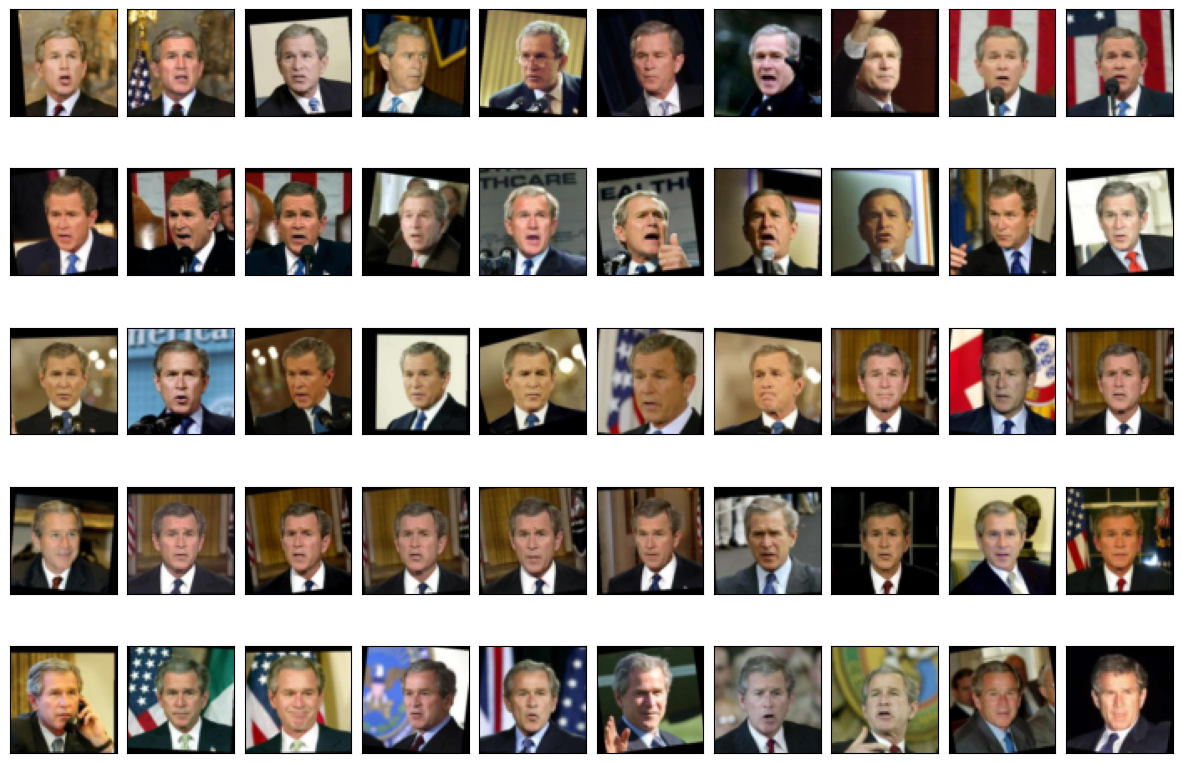

In [5]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [6]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## The Variational Autoencoder
<a id=part2_2></a>

An autoencoder is a model which learns a representation of data in an **unsupervised** fashion (i.e without any labels).
Recall it's general form from the lecture:

<img src="imgs/autoencoder.jpg"/>

An autoencoder maps an instance $\bb{x}$ to a **latent-space** representation $\bb{z}$.
It has an encoder part, $\Phi_{\bb{\alpha}}(\bb{x})$ (a model with parameters $\bb{\alpha}$)
and a decoder part, $\Psi_{\bb{\beta}}(\bb{z})$ (a model with parameters $\bb{\beta}$).

While autoencoders can learn useful representations,
generally it's hard to use them as generative models because there's no distribution we can sample from in the latent space. In other words, we have no way to choose a point $\bb{z}$ in the latent space
such that $\Psi(\bb{z})$ will end up on the data manifold in the instance space.

<img src="imgs/ae_sampling.jpg"/>


The variational autoencoder (VAE), first proposed by [Kingma and Welling](https://arxiv.org/pdf/1312.6114.pdf), addresses this issue by taking a probabilistic perspective. 
Briefly, a VAE model can be described as follows.

We define, in Baysean terminology,
- The **prior** distribution $p(\bb{Z})$ on points in the latent space.
- The **posterior** distribution of points in the latent spaces given a specific instance: $p(\bb{Z}|\bb{X})$.
- The **likelihood** distribution of a sample $\bb{X}$ given a latent-space representation: $p(\bb{X}|\bb{Z})$.
- The **evidence** distribution $p(\bb{X})$ which is the distribution of the instance space due to the generative process.

To create our variational **decoder** we'll further specify:

- A parametric likelihood distribution, $p _{\bb{\beta}}(\bb{X} | \bb{Z}=\bb{z}) = \mathcal{N}( \Psi _{\bb{\beta}}(\bb{z}) , \sigma^2 \bb{I} )$. The interpretation is that given a latent $\bb{z}$, we map it to a point normally distributed around the point calculated by our decoder neural network. Note that here $\sigma^2$ is a hyperparameter while $\vec{\beta}$ represents the network parameters.
- A fixed latent-space prior distribution of $p(\bb{Z}) = \mathcal{N}(\bb{0},\bb{I})$.

This setting allows us to generate a new instance $\bb{x}$ by sampling $\bb{z}$ from the multivariate normal
distribution, obtaining the instance-space mean $\Psi _{\bb{\beta}}(\bb{z})$ using our decoder network,
and then sampling $\bb{x}$ from $\mathcal{N}( \Psi _{\bb{\beta}}(\bb{z}) , \sigma^2 \bb{I} )$.

Our variational **encoder** will approximate the posterior with a parametric distribution 
$q _{\bb{\alpha}}(\bb{Z} | \bb{x}) =
\mathcal{N}( \bb{\mu} _{\bb{\alpha}}(\bb{x}),  \mathrm{diag}\{ \bb{\sigma}^2_{\bb{\alpha}}(\bb{x}) \} )$.
The interpretation is that our encoder model, $\Phi_{\vec{\alpha}}(\bb{x})$, calculates
the mean and variance of the posterior distribution, and samples $\bb{z}$ based on them.
An important nuance here is that our network can't contain any stochastic elements that
depend on the model parameters, otherwise we won't be able to back-propagate to those parameters.
So sampling $\bb{z}$ from $\mathcal{N}( \bb{\mu} _{\bb{\alpha}}(\bb{x}),  \mathrm{diag}\{ \bb{\sigma}^2_{\bb{\alpha}}(\bb{x}) \} )$ is not an option.
The solution is to use what's known as the **reparametrization trick**: sample from an isotropic Gaussian, 
i.e. $\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ (which doesn't depend on trainable parameters), and calculate the latent representation as
$\bb{z} = \bb{\mu} _{\bb{\alpha}}(\bb{x}) + \bb{u}\odot\bb{\sigma}_{\bb{\alpha}}(\bb{x})$.

To train a VAE model, we maximize the evidence distribution, $p(\bb{X})$ (see question below). 
The **VAE loss** can therefore be stated as minimizing $\mathcal{L} = -\mathbb{E}_{\bb{x}} \log p(\bb{X})$.
Although this expectation is intractable,
we can obtain a lower-bound for $p(\bb{X})$ (the evidence lower bound, "ELBO", shown in the lecture):

$$
\log p(\bb{X}) \ge \mathbb{E} _{\bb{z} \sim q _{\bb{\alpha}} }\left[ \log  p _{\bb{\beta}}(\bb{X} | \bb{z}) \right]
-  \mathcal{D} _{\mathrm{KL}}\left(q _{\bb{\alpha}}(\bb{Z} | \bb{X})\,\left\|\, p(\bb{Z} )\right.\right)
$$

where
$
\mathcal{D} _{\mathrm{KL}}(q\left\|\right.p) =
\mathbb{E}_{\bb{z}\sim q}\left[ \log \frac{q(\bb{Z})}{p(\bb{Z})} \right]
$
is the Kullback-Liebler divergence, which can be interpreted as the information gained by using the posterior $q(\bb{Z|X})$ instead of the prior distribution $p(\bb{Z})$.

Using the ELBO, the VAE loss becomes,
$$
\mathcal{L}(\vec{\alpha},\vec{\beta}) = \mathbb{E} _{\bb{x}}  \left[ 
\mathbb{E} _{\bb{z} \sim q _{\bb{\alpha}} }\left[ -\log  p _{\bb{\beta}}(\bb{x} | \bb{z}) \right]
+  \mathcal{D} _{\mathrm{KL}}\left(q _{\bb{\alpha}}(\bb{Z} | \bb{x})\,\left\|\, p(\bb{Z} )\right.\right)
\right].
$$

By remembering that the likelihood is a Gaussian distribution with a diagonal covariance and by applying the reparametrization trick, we can write the above as

$$
\mathcal{L}(\vec{\alpha},\vec{\beta}) = \mathbb{E} _{\bb{x}}  \left[ 
\mathbb{E} _{\bb{z} \sim q _{\bb{\alpha}} }
\left[ 
\frac{1}{2\sigma^2}\left\| \bb{x}- \Psi _{\bb{\beta}}\left(  \bb{\mu} _{\bb{\alpha}}(\bb{x})  + \bb{\Sigma}^{\frac{1}{2}} _{\bb{\alpha}}(\bb{x}) \bb{u}   \right) \right\| _2^2
\right]
+  \mathcal{D} _{\mathrm{KL}}\left(q _{\bb{\alpha}}(\bb{Z} | \bb{x})\,\left\|\, p(\bb{Z} )\right.\right)
\right].
$$



### Model Implementation
<a id=part2_3></a>

Obviously our model will have two parts, an encoder and a decoder.
Since we're working with images, we'll implement both as deep **convolutional** networks, where the decoder is a "mirror image" of the encoder implemented with adjoint (AKA transposed) convolutions.
Between the encoder CNN and the decoder CNN we'll implement the sampling from
the parametric posterior approximator $q_{\bb{\alpha}}(\bb{Z}|\bb{x})$
to make it a VAE model and not just a regular autoencoder (of course, this is not yet enough to create a VAE,
since we also need a special loss function which we'll get to later).

First let's implement just the CNN part of the Encoder network
(this is not the full $\Phi_{\vec{\alpha}}(\bb{x})$ yet).
As usual, it should take an input image and map to a activation volume of a specified depth.
We'll consider this volume as the features we extract from the input image.
Later we'll use these to create the latent space representation of the input.

**TODO**: Implement the `EncoderCNN` class in the `hw3/autoencoder.py` module.
Implement any CNN architecture you like. If you need "architecture inspiration" you can see e.g. [this](https://arxiv.org/pdf/1512.09300.pdf) or [this](https://arxiv.org/pdf/1511.06434.pdf) paper.

In [7]:
import hw3.autoencoder as autoencoder

in_channels = 3
out_channels = 1024
encoder_cnn = autoencoder.EncoderCNN(in_channels, out_channels).to(device)
print(encoder_cnn)

h = encoder_cnn(x0)
print(h.shape)

test.assertEqual(h.dim(), 4)
test.assertSequenceEqual(h.shape[0:2], (1, out_channels))

EncoderCNN(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(256, 1024, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(5, 5)

Now let's implement the CNN part of the Decoder.
Again this is not yet the full $\Psi _{\bb{\beta}}(\bb{z})$. It should take an activation volume produced
by your `EncoderCNN` and output an image of the same dimensions as the Encoder's input was.
This can be a CNN which is like a "mirror image" of the the Encoder. For example, replace convolutions with transposed convolutions, downsampling with up-sampling etc.
Consult the documentation of [ConvTranspose2D](https://pytorch.org/docs/0.4.1/nn.html#convtranspose2d)
to figure out how to reverse your convolutional layers in terms of input and output dimensions. Note that the decoder doesn't have to be exactly the opposite of the encoder and you can experiment with using a different architecture.

**TODO**: Implement the `DecoderCNN` class in the `hw3/autoencoder.py` module.

DecoderCNN(
  (conv1): ConvTranspose2d(1024, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): ConvTranspose2d(64, 3, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (cnn): Sequential(
    (0): ConvTranspose2d(1024, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(

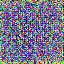

In [8]:
decoder_cnn = autoencoder.DecoderCNN(in_channels=out_channels, out_channels=in_channels).to(device)
print(decoder_cnn)
x0r = decoder_cnn(h)
print(x0r.shape)

test.assertEqual(x0.shape, x0r.shape)

# Should look like colored noise
T.functional.to_pil_image(x0r[0].cpu().detach())

Let's now implement the full VAE Encoder, $\Phi_{\vec{\alpha}}(\vec{x})$.
It will work as follows:
1. Produce a feature vector $\vec{h}$ from the input image $\vec{x}$.
2. Use two affine transforms to convert the features into the mean and log-variance of the posterior, i.e.
    $$
    \begin{align}
        \bb{\mu} _{\bb{\alpha}}(\bb{x}) &= \vec{h}\mattr{W}_{\mathrm{h\mu}} + \vec{b}_{\mathrm{h\mu}} \\
        \log\left(\bb{\sigma}^2_{\bb{\alpha}}(\bb{x})\right) &= \vec{h}\mattr{W}_{\mathrm{h\sigma^2}} + \vec{b}_{\mathrm{h\sigma^2}}
    \end{align}
    $$
3. Use the **reparametrization trick** to create the latent representation $\vec{z}$.

Notice that we model the **log** of the variance, not the actual variance.
The above formulation is proposed in appendix C of the [VAE paper](https://arxiv.org/pdf/1312.6114.pdf).

**TODO**: Implement the `encode()` method in the `VAE` class within the `hw3/autoencoder.py` module.
You'll also need to define your parameters in `__init__()`.

In [9]:
z_dim = 2
vae = autoencoder.VAE(encoder_cnn, decoder_cnn, x0[0].size(), z_dim).to(device)
print(vae)

z, mu, log_sigma2 = vae.encode(x0)

test.assertSequenceEqual(z.shape, (1, z_dim))
test.assertTrue(z.shape == mu.shape == log_sigma2.shape)

print(f'mu(x0)={list(*mu.detach().cpu().numpy())}, sigma2(x0)={list(*torch.exp(log_sigma2).detach().cpu().numpy())}')

VAE(
  (features_encoder): EncoderCNN(
    (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU()
    (conv4): Conv2d(256, 1024, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu4): ReLU()
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

Let's sample some 2d latent representations for an input image `x0` and visualize them.

sampled mu tensor([ 0.7405, -0.1422])
sampled sigma2 tensor([0.8081, 0.9878])


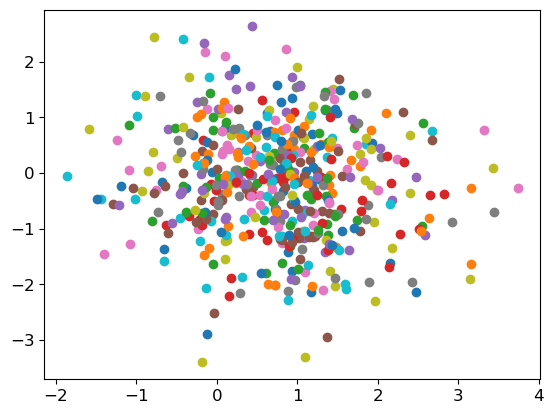

In [10]:
# Sample from q(Z|x)
N = 500
Z = torch.zeros(N, z_dim)
_, ax = plt.subplots()
with torch.no_grad():
    for i in range(N):
        Z[i], _, _ = vae.encode(x0)
        ax.scatter(*Z[i].cpu().numpy())

# Should be close to the mu/sigma in the previous block above
print('sampled mu', torch.mean(Z, dim=0))
print('sampled sigma2', torch.var(Z, dim=0))

Let's now implement the full VAE Decoder, $\Psi _{\bb{\beta}}(\bb{z})$.
It will work as follows:
1. Produce a feature vector $\tilde{\vec{h}}$ from the latent vector $\vec{z}$ using an affine transform.
2. Reconstruct an image $\tilde{\vec{x}}$ from $\tilde{\vec{h}}$ using the decoder CNN.

**TODO**: Implement the `decode()` method in the `VAE` class within the `hw3/autoencoder.py` module.
You'll also need to define your parameters in `__init__()`. You may need to also re-run the block above after you implement this.

In [11]:
x0r = vae.decode(z)

test.assertSequenceEqual(x0r.shape, x0.shape)

Our model's `forward()` function will simply return `decode(encode(x))` as well as the calculated mean and log-variance of the posterior.

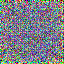

In [12]:
x0r, mu, log_sigma2 = vae(x0)

test.assertSequenceEqual(x0r.shape, x0.shape)
test.assertSequenceEqual(mu.shape, (1, z_dim))
test.assertSequenceEqual(log_sigma2.shape, (1, z_dim))
T.functional.to_pil_image(x0r[0].detach().cpu())

### Loss Implementation
<a id=part2_4></a>

In practice, since we're using SGD, we'll drop the expectation over $\bb{X}$ and instead sample an instance from the training set and compute a point-wise loss. Similarly, we'll drop the expectation over $\bb{Z}$ by sampling from $q_{\vec{\alpha}}(\bb{Z}|\bb{x})$.
Additionally, because the KL divergence is between two Gaussian distributions, there is a closed-form expression for it. These points bring us to the following point-wise loss:

$$
\ell(\vec{\alpha},\vec{\beta};\bb{x}) =
\frac{1}{\sigma^2 d_x} \left\| \bb{x}- \Psi _{\bb{\beta}}\left(  \bb{\mu} _{\bb{\alpha}}(\bb{x})  +
\bb{\Sigma}^{\frac{1}{2}} _{\bb{\alpha}}(\bb{x}) \bb{u}   \right) \right\| _2^2 +
\mathrm{tr}\,\bb{\Sigma} _{\bb{\alpha}}(\bb{x}) +  \|\bb{\mu} _{\bb{\alpha}}(\bb{x})\|^2 _2 - d_z - \log\det \bb{\Sigma} _{\bb{\alpha}}(\bb{x}),
$$

where $d_z$ is the dimension of the latent space, $d_x$ is the dimension of the input and $\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$.
This pointwise loss is the quantity that we'll compute and minimize with gradient descent.
The first term corresponds to the data-reconstruction loss, while the second term corresponds to the KL-divergence loss.
Note that the scaling by $d_x$ is not derived from the original loss formula and was added directly to the pointwise loss just to normalize the data term.

**TODO**: Implement the `vae_loss()` function in the `hw3/autoencoder.py` module.

In [13]:
from hw3.autoencoder import vae_loss
torch.manual_seed(42)

def test_vae_loss():
    # Test data
    N, C, H, W = 10, 3, 64, 64 
    z_dim = 32
    x  = torch.randn(N, C, H, W)*2 - 1
    xr = torch.randn(N, C, H, W)*2 - 1
    z_mu = torch.randn(N, z_dim)
    z_log_sigma2 = torch.randn(N, z_dim)
    x_sigma2 = 0.9
    
    loss, _, _ = vae_loss(x, xr, z_mu, z_log_sigma2, x_sigma2)
    
    test.assertAlmostEqual(loss.item(), 58.3234367, delta=1e-3)
    return loss

test_vae_loss()

tensor(58.3234)

### Sampling
<a id=part2_5></a>

The main advantage of a VAE is that it can by used as a generative model by sampling the latent space, since
we optimize for a isotropic Gaussian prior $p(\bb{Z})$ in the loss function. Let's now implement this so that we can visualize how our model is doing when we train.

**TODO**: Implement the `sample()` method in the `VAE` class within the `hw3/autoencoder.py` module.

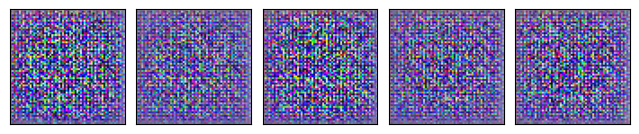

In [14]:
samples = vae.sample(5)
_ = plot.tensors_as_images(samples)

### Training
<a id=part2_6></a>

Time to train!

**TODO**:
1. Implement the `VAETrainer` class in the `hw3/training.py` module. Make sure to implement the `checkpoints` feature of the `Trainer` class if you haven't done so already in Part 1.
2. Tweak the hyperparameters in the `part2_vae_hyperparams()` function within the `hw3/answers.py` module.

In [15]:
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.nn import DataParallel
from hw3.training import VAETrainer
from hw3.answers import part2_vae_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part2_vae_hyperparams()
batch_size = hp['batch_size']
h_dim = hp['h_dim']
z_dim = hp['z_dim']
x_sigma2 = hp['x_sigma2']
learn_rate = hp['learn_rate']
betas = hp['betas']

# Data
split_lengths = [int(len(ds_gwb)*0.9), int(len(ds_gwb)*0.1)]
ds_train, ds_test = random_split(ds_gwb, split_lengths)
dl_train = DataLoader(ds_train, batch_size, shuffle=True)
dl_test  = DataLoader(ds_test,  batch_size, shuffle=True)
im_size = ds_train[0][0].shape

# Model
encoder = autoencoder.EncoderCNN(in_channels=im_size[0], out_channels=h_dim)
decoder = autoencoder.DecoderCNN(in_channels=h_dim, out_channels=im_size[0])
vae = autoencoder.VAE(encoder, decoder, im_size, z_dim)
vae_dp = DataParallel(vae).to(device)

# Optimizer
optimizer = optim.Adam(vae.parameters(), lr=learn_rate, betas=betas)

# Loss
def loss_fn(x, xr, z_mu, z_log_sigma2):
    return autoencoder.vae_loss(x, xr, z_mu, z_log_sigma2, x_sigma2)

# Trainer
trainer = VAETrainer(vae_dp, loss_fn, optimizer, device)
checkpoint_file = 'checkpoints/vae'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show model and hypers
print(vae)
print(hp)

VAE(
  (features_encoder): EncoderCNN(
    (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU()
    (conv4): Conv2d(256, 1024, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu4): ReLU()
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

**TODO**:
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training. Note that your final submission zip will not include the `checkpoints/` folder. This is OK.

The images you get should be colorful, with different backgrounds and poses.

--- EPOCH 1/200 ---
test_batch (Avg. Loss 328.212, Accuracy 0.0): 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]
*** Saved checkpoint checkpoints/vae.pt at epoch 1


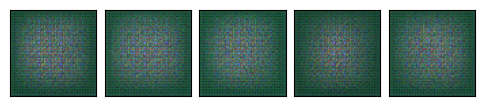

test_batch (Avg. Loss 303.639, Accuracy 0.0): 100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.75it/s]
*** Saved checkpoint checkpoints/vae.pt at epoch 2
test_batch (Avg. Loss 292.661, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  5.73it/s]
*** Saved checkpoint checkpoints/vae.pt at epoch 3
test_batch (Avg. Loss 282.751, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]
*** Saved checkpoint checkpoints/vae.pt at epoch 4
test_batch (Avg. Loss 264.908, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  5.23it/s]
*** Saved checkpoint checkpoints/vae.pt at epoch 5
test_batch (Avg. Loss 249.626, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  5.65it/s]
*** Saved checkpoint checkpoints/vae.pt at epoch 6
test_batch (Avg. Loss 260.897, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  4.96it/s]
Early stopping at epoch 7
*** Save

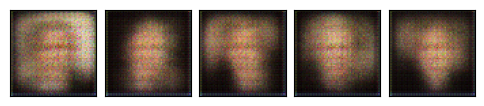

test_batch (Avg. Loss 222.554, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  5.85it/s]
*** Saved checkpoint checkpoints/vae.pt at epoch 12
test_batch (Avg. Loss 242.365, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  5.69it/s]
Early stopping at epoch 13
*** Saved checkpoint checkpoints/vae.pt at epoch 13
test_batch (Avg. Loss 209.575, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]
*** Saved checkpoint checkpoints/vae.pt at epoch 14
test_batch (Avg. Loss 210.014, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  5.86it/s]
Early stopping at epoch 15
*** Saved checkpoint checkpoints/vae.pt at epoch 15
test_batch (Avg. Loss 218.577, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]
Early stopping at epoch 16
*** Saved checkpoint checkpoints/vae.pt at epoch 16
test_batch (Avg. Loss 206.818, Accuracy 0.0): 100%|█████████████████████████████████

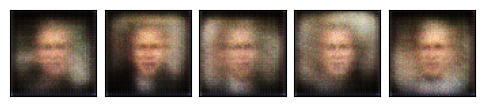

test_batch (Avg. Loss 222.091, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  5.65it/s]
Early stopping at epoch 22
*** Saved checkpoint checkpoints/vae.pt at epoch 22
test_batch (Avg. Loss 216.683, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  5.62it/s]
Early stopping at epoch 23
*** Saved checkpoint checkpoints/vae.pt at epoch 23
test_batch (Avg. Loss 194.038, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  5.64it/s]
*** Saved checkpoint checkpoints/vae.pt at epoch 24
test_batch (Avg. Loss 199.528, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  5.65it/s]
Early stopping at epoch 25
*** Saved checkpoint checkpoints/vae.pt at epoch 25
test_batch (Avg. Loss 193.876, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  5.65it/s]
*** Saved checkpoint checkpoints/vae.pt at epoch 26
test_batch (Avg. Loss 197.102, Accuracy 0.0): 100%|█████████████████████████████████

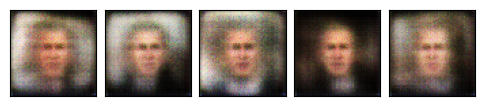

test_batch (Avg. Loss 196.845, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  5.64it/s]
Early stopping at epoch 32
*** Saved checkpoint checkpoints/vae.pt at epoch 32
test_batch (Avg. Loss 187.865, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  5.52it/s]
*** Saved checkpoint checkpoints/vae.pt at epoch 33
test_batch (Avg. Loss 188.287, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.05it/s]
Early stopping at epoch 34
*** Saved checkpoint checkpoints/vae.pt at epoch 34
test_batch (Avg. Loss 187.162, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  4.70it/s]
*** Saved checkpoint checkpoints/vae.pt at epoch 35
test_batch (Avg. Loss 196.466, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  7.55it/s]
Early stopping at epoch 36
*** Saved checkpoint checkpoints/vae.pt at epoch 36
test_batch (Avg. Loss 192.223, Accuracy 0.0): 100%|█████████████████████████████████

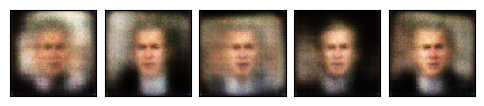

test_batch (Avg. Loss 191.652, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  7.69it/s]
Early stopping at epoch 42
*** Saved checkpoint checkpoints/vae.pt at epoch 42
test_batch (Avg. Loss 188.907, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.08it/s]
Early stopping at epoch 43
*** Saved checkpoint checkpoints/vae.pt at epoch 43
test_batch (Avg. Loss 179.643, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.11it/s]
*** Saved checkpoint checkpoints/vae.pt at epoch 44
test_batch (Avg. Loss 180.140, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  6.54it/s]
Early stopping at epoch 45
*** Saved checkpoint checkpoints/vae.pt at epoch 45
test_batch (Avg. Loss 187.552, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.25it/s]
Early stopping at epoch 46
*** Saved checkpoint checkpoints/vae.pt at epoch 46
test_batch (Avg. Loss 186.528, Accuracy 0.0): 100%|██████

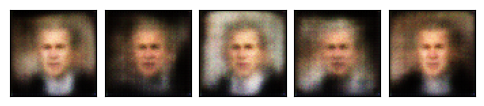

test_batch (Avg. Loss 175.602, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.20it/s]
Early stopping at epoch 52
*** Saved checkpoint checkpoints/vae.pt at epoch 52
test_batch (Avg. Loss 175.237, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.28it/s]
Early stopping at epoch 53
*** Saved checkpoint checkpoints/vae.pt at epoch 53
test_batch (Avg. Loss 177.181, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.20it/s]
Early stopping at epoch 54
*** Saved checkpoint checkpoints/vae.pt at epoch 54
test_batch (Avg. Loss 181.168, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.20it/s]
Early stopping at epoch 55
*** Saved checkpoint checkpoints/vae.pt at epoch 55
test_batch (Avg. Loss 181.761, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  7.60it/s]
Early stopping at epoch 56
*** Saved checkpoint checkpoints/vae.pt at epoch 56
test_batch (Avg. Loss 176.720,

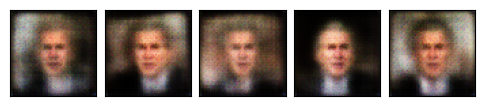

test_batch (Avg. Loss 176.820, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.36it/s]
Early stopping at epoch 62
*** Saved checkpoint checkpoints/vae.pt at epoch 62
test_batch (Avg. Loss 171.562, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  7.72it/s]
*** Saved checkpoint checkpoints/vae.pt at epoch 63
test_batch (Avg. Loss 170.707, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.30it/s]
*** Saved checkpoint checkpoints/vae.pt at epoch 64
test_batch (Avg. Loss 172.195, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.06it/s]
Early stopping at epoch 65
*** Saved checkpoint checkpoints/vae.pt at epoch 65
test_batch (Avg. Loss 176.744, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.25it/s]
Early stopping at epoch 66
*** Saved checkpoint checkpoints/vae.pt at epoch 66
test_batch (Avg. Loss 171.565, Accuracy 0.0): 100%|█████████████████████████████████

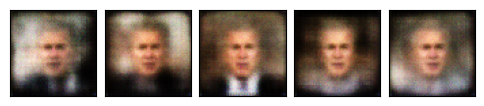

test_batch (Avg. Loss 176.391, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.16it/s]
Early stopping at epoch 72
*** Saved checkpoint checkpoints/vae.pt at epoch 72
test_batch (Avg. Loss 180.801, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.06it/s]
Early stopping at epoch 73
*** Saved checkpoint checkpoints/vae.pt at epoch 73
test_batch (Avg. Loss 174.847, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  6.34it/s]
Early stopping at epoch 74
*** Saved checkpoint checkpoints/vae.pt at epoch 74
test_batch (Avg. Loss 172.666, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  7.83it/s]
Early stopping at epoch 75
*** Saved checkpoint checkpoints/vae.pt at epoch 75
test_batch (Avg. Loss 178.987, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.31it/s]
Early stopping at epoch 76
*** Saved checkpoint checkpoints/vae.pt at epoch 76
test_batch (Avg. Loss 169.888,

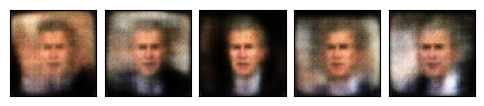

test_batch (Avg. Loss 172.263, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  7.90it/s]
Early stopping at epoch 82
*** Saved checkpoint checkpoints/vae.pt at epoch 82
test_batch (Avg. Loss 166.571, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.10it/s]
*** Saved checkpoint checkpoints/vae.pt at epoch 83
test_batch (Avg. Loss 167.410, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.28it/s]
Early stopping at epoch 84
*** Saved checkpoint checkpoints/vae.pt at epoch 84
test_batch (Avg. Loss 175.999, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.15it/s]
Early stopping at epoch 85
*** Saved checkpoint checkpoints/vae.pt at epoch 85
test_batch (Avg. Loss 170.488, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.21it/s]
Early stopping at epoch 86
*** Saved checkpoint checkpoints/vae.pt at epoch 86
test_batch (Avg. Loss 171.397, Accuracy 0.0): 100%|██████

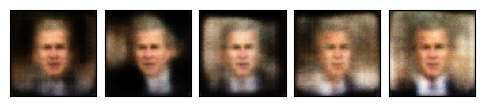

test_batch (Avg. Loss 167.792, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.20it/s]
Early stopping at epoch 92
*** Saved checkpoint checkpoints/vae.pt at epoch 92
test_batch (Avg. Loss 167.268, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  7.08it/s]
Early stopping at epoch 93
*** Saved checkpoint checkpoints/vae.pt at epoch 93
test_batch (Avg. Loss 169.481, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.18it/s]
Early stopping at epoch 94
*** Saved checkpoint checkpoints/vae.pt at epoch 94
test_batch (Avg. Loss 169.533, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.08it/s]
Early stopping at epoch 95
*** Saved checkpoint checkpoints/vae.pt at epoch 95
test_batch (Avg. Loss 165.745, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  7.18it/s]
*** Saved checkpoint checkpoints/vae.pt at epoch 96
test_batch (Avg. Loss 177.854, Accuracy 0.0): 100%|██████

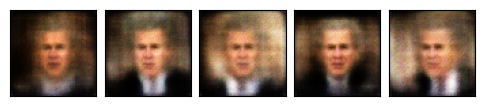

test_batch (Avg. Loss 167.727, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  6.70it/s]
Early stopping at epoch 102
*** Saved checkpoint checkpoints/vae.pt at epoch 102
test_batch (Avg. Loss 171.844, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.20it/s]
Early stopping at epoch 103
*** Saved checkpoint checkpoints/vae.pt at epoch 103
test_batch (Avg. Loss 170.434, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.15it/s]
Early stopping at epoch 104
*** Saved checkpoint checkpoints/vae.pt at epoch 104
test_batch (Avg. Loss 167.619, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.12it/s]
Early stopping at epoch 105
*** Saved checkpoint checkpoints/vae.pt at epoch 105
test_batch (Avg. Loss 165.192, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  7.70it/s]
Early stopping at epoch 106
*** Saved checkpoint checkpoints/vae.pt at epoch 106
test_batch (Avg. Los

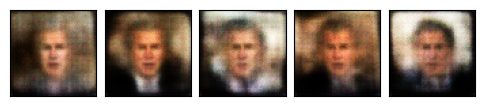

test_batch (Avg. Loss 174.705, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  5.74it/s]
Early stopping at epoch 112
*** Saved checkpoint checkpoints/vae.pt at epoch 112
test_batch (Avg. Loss 168.996, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.17it/s]
Early stopping at epoch 113
*** Saved checkpoint checkpoints/vae.pt at epoch 113
test_batch (Avg. Loss 169.032, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.23it/s]
Early stopping at epoch 114
*** Saved checkpoint checkpoints/vae.pt at epoch 114
test_batch (Avg. Loss 168.487, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.21it/s]
Early stopping at epoch 115
*** Saved checkpoint checkpoints/vae.pt at epoch 115
test_batch (Avg. Loss 164.594, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.22it/s]
Early stopping at epoch 116
*** Saved checkpoint checkpoints/vae.pt at epoch 116
test_batch (Avg. Los

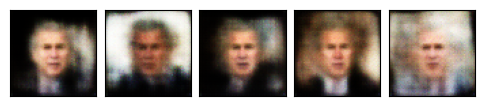

test_batch (Avg. Loss 164.942, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  7.80it/s]
Early stopping at epoch 122
*** Saved checkpoint checkpoints/vae.pt at epoch 122
test_batch (Avg. Loss 165.971, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]
Early stopping at epoch 123
*** Saved checkpoint checkpoints/vae.pt at epoch 123
test_batch (Avg. Loss 164.451, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  7.58it/s]
Early stopping at epoch 124
*** Saved checkpoint checkpoints/vae.pt at epoch 124
test_batch (Avg. Loss 168.468, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.14it/s]
Early stopping at epoch 125
*** Saved checkpoint checkpoints/vae.pt at epoch 125
test_batch (Avg. Loss 166.737, Accuracy 0.0): 100%|█████████████████████████████████| 1/1 [00:00<00:00,  8.22it/s]
Early stopping at epoch 126
*** Saved checkpoint checkpoints/vae.pt at epoch 126
test_batch (Avg. Los

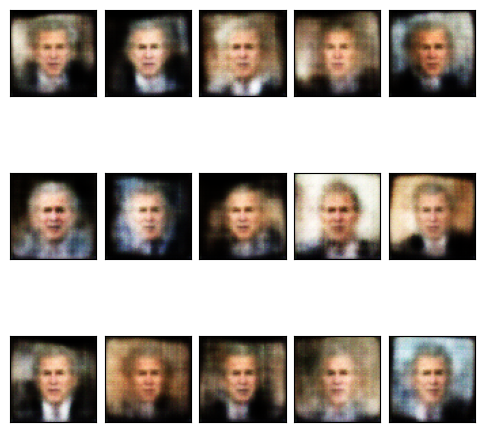

In [16]:
import IPython.display

def post_epoch_fn(epoch, train_result, test_result, verbose):
    # Plot some samples if this is a verbose epoch
    if verbose:
        samples = vae.sample(n=5)
        fig, _ = plot.tensors_as_images(samples, figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    checkpoint_file = checkpoint_file_final
else:
    res = trainer.fit(dl_train, dl_test,
                      num_epochs=200, early_stopping=20, print_every=10,
                      checkpoints=checkpoint_file,
                      post_epoch_fn=post_epoch_fn)
    
# Plot images from best model
saved_state = torch.load(f'{checkpoint_file}.pt', map_location=device)
vae_dp.load_state_dict(saved_state['model_state'])
print('*** Images Generated from best model:')
fig, _ = plot.tensors_as_images(vae_dp.module.sample(n=15), nrows=3, figsize=(6,6))

## Questions
<a id=part2_7></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [17]:
from cs236781.answers import display_answer
import hw3.answers

### Question 1

What does the $\sigma^2$ hyperparameter (`x_sigma2` in the code) do? Explain the effect of low and high values.

In [18]:
display_answer(hw3.answers.part2_q1)


The sigma squared here is a hyperparameter used to construct the loss function. It divides the first part of the loss
if the vae, which is the MSE loss of the prediction from the actual distribution. When x_sigma2 is increased, we panalyze less on this part of the loss, and we increase
the significance of the kldiv loss - which measures the similatiry of the distribution we produced to a normal distribution.
This means we only care about producing a normal distribution over the latent space, and we don't care about the proximity of our produced samples to the actual distribution.
What will happen is that even though sampling works good, the actual images produced will be not that close to the original images.

On the opposite, when we decrease x_sigma2, we increase the weight of the MSE loss of the prediction to the actual distribution, and we care less about the kldiv part of the loss.
The affect would be that even though we are able to memorize the training data and get good results on the samples from it,
the sampling will now work and when we try to create new samples by sampling from a gaussian we will get poorly produced samples.


### Question 2

1. Explain the purpose of both parts of the VAE loss term - reconstruction loss and KL divergence loss.
2. How is the latent-space distribution affected by the KL loss term?
3. What's the benefit of this effect?

In [19]:
display_answer(hw3.answers.part2_q2)


1. The reconstruction loss is the MSE loss of the prediction from the actual distribution - this is important to actually produce images that are close to the 
original distribution.
The kldiv loss is the KL divergence between the distribution we produced and a normal distribution. This part is crucial for the sampling to work - 
we want to sample from a normal distribution for the sampling to work.
2. The kldiv term in the loss measures the simpliary of the posterior of the encoder in the latent space - how likely we are to get z for x given sample x.
Because for sampling we want to use a regular gaussian distribution, we want the posterior to be as close to a gaussian as possible.
The kldiv term minimizes the distance between the posterior and a gaussian distribution.
3. This affect is crucial for the sampling to work and create good samples in the input space.
It improves generalization - we require the model to create a smooth distribution of the encoder over the latent space, and not send different samples to different regions in that space.


### Question 3

In the formulation of the VAE loss, why do we start by maximizing the evidence 
distribution, $p(X)$?

In [20]:
display_answer(hw3.answers.part2_q3)


In generative models, we want to study a distibution that matches our samples.
To do that, we want to maximize the likelihood of the samples given by some distribution.
This is a general term for training generative models - we want to maximize the likelihood of the samples given by the model.


### Question 4

In the VAE encoder, why do we model the **log** of the 
latent-space variance corresponding to an input, $\sigma^2_{\alpha}$,
instead of directly modelling this variance?

In [21]:
display_answer(hw3.answers.part2_q4)


The reason we use the log of the varience, is that because varience is strictly positive, but the model could learn negative values as well.
For the model to learn the varience, it needs to be positive, and the log of the varience is a way to ensure that.
